# Tryout Notebook for ResNet50 model for binary classification

Source of idea: https://www.ejcancer.com/article/S0959-8049(19)30349-1/fulltext#secsectitle0050 Chapter 2.2 Methods

#### Pretrained ResNet50 CNN:

* ResNet50 Model: ResNet50 is a deep convolutional neural network architecture originally designed for image classification tasks. It consists of 50 layers, including convolutional layers, batch normalization, and skip connections (residual connections), which allow it to effectively learn from very deep networks. The model is pretrained on a large dataset (typically ImageNet) to capture a wide range of features from images

* Transfer Learning: In transfer learning, we start with a pretrained model (ResNet50 in this case) and fine-tune it for a specific task. By doing this, we leverage the knowledge the model has gained from the original dataset and adapt it to a new task, such as classifying skin lesions

## Imports and inital setup

In [1]:
# Imports
import pandas as pd

from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

import sys

sys.path.append("..")
from helperfunctions import modelhelper as mh
from helperfunctions import imagehelper as ih

SEED = 45
NUM_EPOCHS = 20

# File path variables
# please make sure to use the correct path to the meta data file

FILEPATH_JPGS = './../data/jpgs/'
FILEPATH_PROCESSED="./../data/processed/"
FILEPATH_OUTPUT = './../data/jpgs/'  # Replace with your folder path

TARGET_LABEL="dx"
BALANCE_LABEL="dx"
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 16

### Loading (augmented) metadata as test, train, validation from files

In [2]:
# Read the metadata file
train_df = pd.read_csv(FILEPATH_PROCESSED+"train_from_Metadata_processed.csv")
validation_df = pd.read_csv(FILEPATH_PROCESSED+"validation_from_Metadata_processed.csv")
test_df = pd.read_csv(FILEPATH_PROCESSED+"test_from_Metadata_processed.csv")

train_df.sample(15)

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,dx_binary,image_path
2724,HAM_0005026,aug_qHDZLLISIC_0028728.jpg,bcc,histo,40.0,female,abdomen,vidir_modern,skin_cancer,./../data/jpgs/aug_qHDZLLISIC_0028728.jpg
2678,HAM_0005984,aug_PqL39ZISIC_0026117.jpg,bcc,histo,75.0,female,face,rosendahl,skin_cancer,./../data/jpgs/aug_PqL39ZISIC_0026117.jpg
5197,HAM_0007396,aug_DXrMHzISIC_0033810.jpg,df,consensus,35.0,female,lower extremity,vidir_modern,not_skin_cancer,./../data/jpgs/aug_DXrMHzISIC_0033810.jpg
1707,HAM_0003129,ISIC_0029195.jpg,bkl,consensus,75.0,female,trunk,vidir_molemax,not_skin_cancer,./../data/jpgs/ISIC_0029195.jpg
2241,HAM_0000744,ISIC_0029525.jpg,bkl,histo,70.0,male,face,rosendahl,not_skin_cancer,./../data/jpgs/ISIC_0029525.jpg
444,HAM_0004357,ISIC_0027985.jpg,nv,follow_up,55.0,female,foot,vidir_molemax,not_skin_cancer,./../data/jpgs/ISIC_0027985.jpg
3840,HAM_0007008,ISIC_0031292.jpg,akiec,histo,60.0,male,hand,rosendahl,skin_cancer,./../data/jpgs/ISIC_0031292.jpg
435,HAM_0005152,ISIC_0030112.jpg,nv,follow_up,40.0,male,abdomen,vidir_molemax,not_skin_cancer,./../data/jpgs/ISIC_0030112.jpg
3721,HAM_0000502,aug_l8u7UiISIC_0031093.jpg,vasc,consensus,70.0,male,back,vidir_modern,not_skin_cancer,./../data/jpgs/aug_l8u7UiISIC_0031093.jpg
4960,HAM_0006371,aug_NNmc7eISIC_0034135.jpg,df,consensus,35.0,female,lower extremity,vidir_modern,not_skin_cancer,./../data/jpgs/aug_NNmc7eISIC_0034135.jpg


## Setting up the image data generator for training and validation

In [3]:
from tensorflow.keras.applications.resnet50 import preprocess_input

def custom_preprocessing(np_image, image_size):
    np_image = ih.center_crop_image(np_image) # Crop image to square format
    np_image = ih.resize_as_preprocess(np_image, image_size) # resize the image
    np_image = preprocess_input(np_image) # Apply the preprocess_input function of MobileNetV3Large
    return np_image

In [4]:
# Setting up the Image Data Generator for the train data set - including augmentation


datagen_train = ImageDataGenerator(
    rescale=1.0 / 255.0, # Rescale pixel values to [0, 1], important for CNNs to perform better
    preprocessing_function=lambda x: custom_preprocessing(x, IMAGE_SIZE), # Apply the custom preprocessing function 
)

datagen_validation = ImageDataGenerator(
    rescale=1.0 / 255.0,
    preprocessing_function=lambda x: custom_preprocessing(x, IMAGE_SIZE)
)

validation_generator = datagen_validation.flow_from_dataframe(
    dataframe=validation_df,
    directory=FILEPATH_JPGS,
    x_col="image_id",
    y_col=TARGET_LABEL,
    class_mode="categorical",
    target_size=IMAGE_SIZE,
    batch_size=32
)

train_data_generator = datagen_train.flow_from_dataframe(
        dataframe=train_df,
        directory=FILEPATH_JPGS,
        x_col="image_id",
        y_col=TARGET_LABEL,
        class_mode="categorical",
        target_size=IMAGE_SIZE,
        batch_size=32
)

Found 1001 validated image filenames belonging to 7 classes.


Found 5254 validated image filenames belonging to 7 classes.


## ResNet50


In [5]:
#defining a learning rate scheduler
import math
from tensorflow.keras.callbacks import LearningRateScheduler

# Define a learning rate schedule function
def lr_schedule(epoch):
    """
    Learning rate schedule function.
    
    Args:
        epoch (int): The current epoch number.
        
    Returns:
        float: The learning rate for the current epoch.
    """
    initial_lr = 0.0001  # Initial learning rate
    drop = 0.5  # Learning rate drop factor
    epochs_drop = 5  # Number of epochs after which learning rate will drop

    # Calculate the learning rate for the current epoch
    lr = initial_lr * math.pow(drop, math.floor((1 + epoch) / epochs_drop))
    return lr

# Create a LearningRateScheduler callback
lr_scheduler = LearningRateScheduler(lr_schedule)

In [6]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Conv2D, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
import math

# Create a base ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3)) # use the pretrained weights of the imagenet dataset, include_top=False means that we do not want to include the last layer of the model
num_classes = len(train_data_generator.class_indices) 

# Freeze layers in the base model
for layer in base_model.layers:
    layer.trainable = True

# Add custom layers for classification
x = base_model.output
x = Conv2D(64, (3, 3), activation='relu')(x)
x = GlobalAveragePooling2D()(x) # GlobalAveragePooling2D reduces the spatial dimensions of the output
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x) 
#x = Conv2D(64, (3, 3), activation='relu')(x) --> this made things worse... could still be interesting to add a conv block here though...
#x = GlobalAveragePooling2D()(x) # GlobalAveragePooling2D reduces the spatial dimensions of the output
#x = Dense(1024, activation='relu')(x) # fully connected layer with 1024 neurons and ReLU activation, relu is used to introduce non-linearity
x= Dense(7, activation='softmax')(x) #  output layer with a number of neurons equal to the number of classes (determined by num_classes) and a softmax activation function for multi-class classification.

# Create the final model
model = Model(inputs=base_model.input, outputs=x, name="ResNet50_pretrained_7_classes_updated_architecture_bigger_training_set")

from tensorflow.keras.optimizers import SGD
# Define the SGD optimizer with specific parameters
sgd_optimizer = SGD(learning_rate=0.0001, momentum=0.9, nesterov=False)
# Compile the model 

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

Model: "ResNet50_pretrained_7_classes_updated_architecture_bigger_training_set"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                         

## Model Training

In [7]:
from sklearn.utils import class_weight
import numpy as np
class_weights = class_weight.compute_class_weight('balanced',
                                                 classes=np.unique(train_df[TARGET_LABEL]),
                                                    y=train_df[TARGET_LABEL])
class_weights = dict(enumerate(class_weights))
class_weights

{0: 0.999429332318813,
 1: 0.999429332318813,
 2: 1.0007619047619047,
 3: 0.999429332318813,
 4: 1.0007619047619047,
 5: 1.0007619047619047,
 6: 0.999429332318813}

in callbacks its possbile to add checkpoints, lr_scheduler, early stopping, tensorboard etc...

In [8]:
# Train the model

history = model.fit(
    train_data_generator,
    epochs=NUM_EPOCHS,              
    verbose=1,                      # Adjust verbosity level
    batch_size=BATCH_SIZE,                # Set the batch size, default is 32, can be increased to speed up training, but memory consumption increases
    callbacks=[lr_scheduler],                 # List of callbacks to apply during training 
    validation_split=0.0,           # not needed as we use a validation data generator
    validation_data=validation_generator,
    shuffle=True,                   # Shuffle the training data before each epoch
    sample_weight=None,             # Set the weights for the train data set !
    class_weight=class_weights,              # Set the weights for the classes, not needed if we use sample weights
    initial_epoch=0,                # Use this to continue training from a specific epoch
    steps_per_epoch=None,           # Set the number of steps per epoch, default is len(x_train) // batch_size
    validation_steps=None,          # Set the number of steps for validation, default is len(x_val) // batch_size
    validation_batch_size=None,     # Set the batch size for validation, default is batch_size
    validation_freq=1,              # Only relevant if validation data is a generator. Set the frequency to validate the model on the validation set
    max_queue_size=10,              # Set the max size for the generator queue
    workers=-1,                     # Set the max number of processes to generate the data in parallel, -1 means all CPUs
    use_multiprocessing=False       # Set to True if you use a generator in parallel, e.g. model.predict_generator()
)

Epoch 1/20
165/165 [==============================] - 1023s 6s/step - loss: 1.4009 - accuracy: 0.4764 - val_loss: 2.3558 - val_accuracy: 0.0140 - lr: 1.0000e-04
Epoch 2/20
165/165 [==============================] - 1049s 6s/step - loss: 0.9733 - accuracy: 0.6492 - val_loss: 3.2961 - val_accuracy: 0.0140 - lr: 1.0000e-04
Epoch 3/20
165/165 [==============================] - 1041s 6s/step - loss: 0.7878 - accuracy: 0.7246 - val_loss: 10.1734 - val_accuracy: 0.0140 - lr: 1.0000e-04
Epoch 4/20
165/165 [==============================] - 1029s 6s/step - loss: 0.6441 - accuracy: 0.7771 - val_loss: 1.2445 - val_accuracy: 0.6693 - lr: 1.0000e-04
Epoch 5/20
165/165 [==============================] - 1041s 6s/step - loss: 0.4287 - accuracy: 0.8494 - val_loss: 1.5811 - val_accuracy: 0.6693 - lr: 5.0000e-05
Epoch 6/20
165/165 [==============================] - 986s 6s/step - loss: 0.2999 - accuracy: 0.8965 - val_loss: 7.6721 - val_accuracy: 0.0140 - lr: 5.0000e-05
Epoch 7/20
165/165 [==============

## Plotting accuracy and loss of train and validation set

(0.0, 1.0)

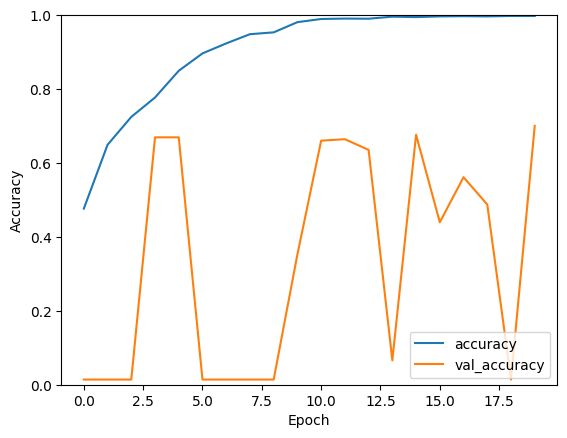

In [9]:
import matplotlib.pyplot as plt
mh.model_plot_accuracy(history)
plt.ylim(0,1)

## Evaluating the model on the test set

 > Evaluating model ResNet50_pretrained_7_classes_updated_architecture_bigger_training_set:
 > Loading test images...
 > Test images loaded.


 > Converting labels to one hot format...
 > Getting model predictions...
32/32 [==============================] - 43s 1s/step
 > Model predictions obtained.
 > Macro AUC: 0.5
 > Micro AUC: 0.4248170326014637


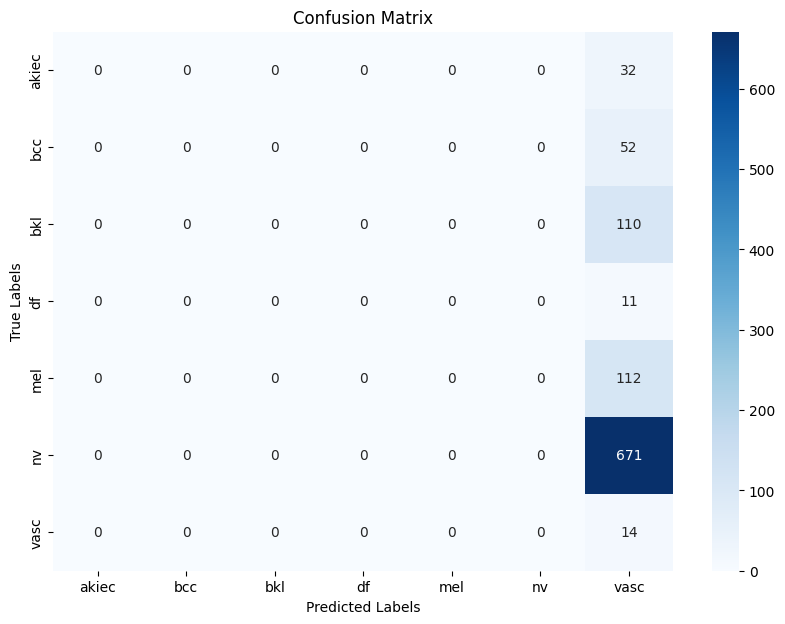



 > Computing classification report...
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        32
           1       0.00      0.00      0.00        52
           2       0.00      0.00      0.00       110
           3       0.00      0.00      0.00        11
           4       0.00      0.00      0.00       112
           5       0.00      0.00      0.00       671
           6       0.01      1.00      0.03        14

    accuracy                           0.01      1002
   macro avg       0.00      0.14      0.00      1002
weighted avg       0.00      0.01      0.00      1002

 > Evaluating model on test set...


/Users/janicepelzer/Documents/neuefische/capstone-healthy-skin/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/janicepelzer/Documents/neuefische/capstone-healthy-skin/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/janicepelzer/Documents/neuefische/capstone-healthy-skin/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. U

32/32 [==============================] - 44s 1s/step - loss: 669.9277 - accuracy: 0.0140
loss: 669.9276733398438
accuracy: 0.013972056098282337
 > Done.


([{'loss': 669.9276733398438}, {'accuracy': 0.013972056098282337}],
 array([[  0,   0,   0,   0,   0,   0,  32],
        [  0,   0,   0,   0,   0,   0,  52],
        [  0,   0,   0,   0,   0,   0, 110],
        [  0,   0,   0,   0,   0,   0,  11],
        [  0,   0,   0,   0,   0,   0, 112],
        [  0,   0,   0,   0,   0,   0, 671],
        [  0,   0,   0,   0,   0,   0,  14]]),
 (0.4248170326014637, 0.5))

In [10]:
mh.model_accuracy_on_test(model, test_df, TARGET_LABEL, IMAGE_SIZE)

## Saving the model

In [11]:
from datetime import datetime
timestamp = datetime.now()
model_path = f"../models/model_{timestamp}.h5"
model.save(model_path)

/Users/janicepelzer/Documents/neuefische/capstone-healthy-skin/.venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
